In [1]:
% matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

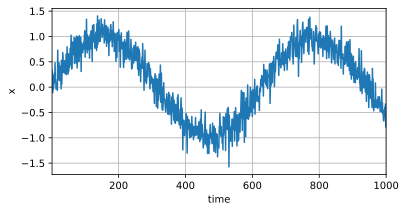

In [2]:
T = 1000
time = torch.arange(1, T + 1, dtype=torch.float32)  # 1到1000为时间
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [3]:
tau = 4
features = torch.zeros((T - tau, tau))  # T - tau 为样本数，tau 为特征数

In [14]:
features.shape

torch.Size([996, 4])

In [6]:
for i in range(tau):
    # 每四个数据作为特征，第五个作为标签，不断构造这样的数据形成数据集
    features[:, i] = x[i:T - tau + i]
# 所从第5个时刻开始，每个时刻的label是该时刻的x值，该时刻的输入是前4个时刻的数值组成的一个向量。
# 经过变化后数据的输入共有996组4个一组的数据，输出共996个值
labels = x[tau:].reshape((-1, 1))
batch_size, n_train = 16, 600
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

In [7]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)


def get_net():
    net = nn.Sequential(nn.Linear(4, 10), nn.ReLU(), nn.Linear(10, 1))
    net.apply(init_weights)
    return net


loss = nn.MSELoss()

In [8]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')


net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.052161
epoch 2, loss: 0.052763
epoch 3, loss: 0.048869
epoch 4, loss: 0.049747
epoch 5, loss: 0.048633


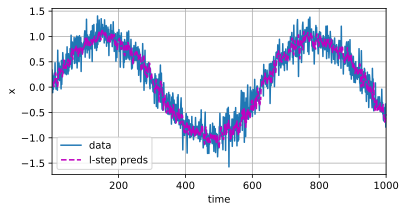

In [9]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time', 'x',
         legend=['data', 'l-step preds'], xlim=[1, 1000], figsize=(6, 3))

In [10]:
multistep_preds = torch.zeros(T)
multistep_preds[:n_train + tau] = x[:n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape((1, -1)))

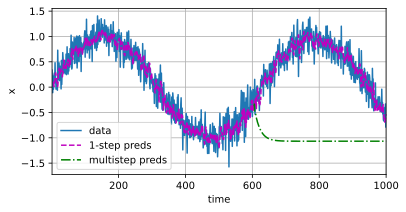

In [12]:
d2l.plot(
    [time, time[tau:], time[n_train + tau:]],
    [x.detach().numpy(), onestep_preds.detach().numpy(), multistep_preds[n_train + tau:].detach().numpy()],
    'time',
    'x',
    legend=['data', '1-step preds', 'multistep preds'],
    xlim=[1, 1000],
    figsize=(6, 3))

In [15]:
max_steps = 64
features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
for i in range(tau):
    features[:, i] = x[i:i + T - tau - max_steps + 1]

for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

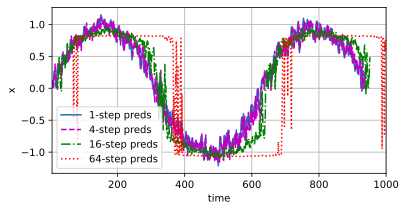

In [16]:
steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1:T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps],
         'time',
         'x',
         legend=[f'{i}-step preds' for i in steps],
         xlim=[5, 1000],
         figsize=(6, 3))